In [17]:
import random

from model import GeneratorModule
from scripts.datasetscripts import parse_concatenated_json, format_augmented_goal
import torch

In [18]:
ckpt_path = "/Users/artem.semidetnov/Desktop/MetaGenerator_v1/.cadence/cache/id2f7519f525f7457f899938c06c46d14c/45602/outputs/lightning_logs/version_6/checkpoints/last.ckpt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GeneratorModule.load_from_checkpoint(ckpt_path, strict=False)
model.to(device)
model.eval()

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5ae6b986-4e75-4701-9edc-d0485b83b5b0)')' thrown while requesting HEAD https://huggingface.co/google/byt5-small/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


GeneratorModule(
  (generator): T5ForConditionalGeneration(
    (shared): Embedding(384, 1472)
    (encoder): T5Stack(
      (embed_tokens): Embedding(384, 1472)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1472, out_features=384, bias=False)
                (k): Linear(in_features=1472, out_features=384, bias=False)
                (v): Linear(in_features=1472, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=1472, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=1472, out_features=3584, bias=False)
                (wi_1)

In [43]:
test_prompts = parse_concatenated_json('../datasets/dataset1/test.json')
def test_model(prompt_index : int) -> None:
    prompt = test_prompts[prompt_index]

    prompt_ = format_augmented_goal(
            prompt["Expected type"],
            prompt["Premises"],
            512,
            0.0,
        )
    prompts = [prompt_]
    enc = model.tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=getattr(model.hparams, "max_inp_seq_len", 512),
        return_tensors="pt",
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        outputs = model.generator.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            num_beams=4,#getattr(model.hparams, "num_beams", 4),
            num_return_sequences=4,
            length_penalty=getattr(model.hparams, "length_penalty", 0.0),
            max_length=getattr(model.hparams, "max_oup_seq_len", 128),
        )

    preds = model.tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return preds, prompt['Expression']

In [44]:
for i in range(3):
    print(str(test_model(i)[0]) + '\n true value = ' + str(test_model(i)[1]))
    print("-------------------")

['\\lam j => {?}', '\\lam p => {?}', '\\lam {x} => {?}', 'rewrite (\\peval partialSum _ _) {?}']
 true value = \lam _ => {?}
-------------------
['\\lam {x} => {?}', '\\lam p0 => {?}', '\\lam p => {?}', 'propExt {?} {?}']
 true value = cover-inj {?} idp
-------------------
['\\lam p0 => {?}', '\\lam {x} => {?}', '\\lam p => {?}', 'inP (U, V, DU, idp)']
 true value = rewrite p {?}
-------------------


In [37]:
!wc -l /Users/artem.semidetnov/Desktop/MetaGenerator_v1/dataset_small/train.json

wc: /Users/artem.semidetnov/Desktop/MetaGenerator_v1/dataset_small/train.json: open: No such file or directory


[0] rewrite (get-leaf {this}) (rewrite (get-leaf {this}) (rewrite (get-leaf {this}) idp))


In [8]:
model.training

False

## New

In [45]:
# Check data
x = parse_concatenated_json('/Users/artem.semidetnov/Desktop/MetaGenerator_v1/datasets/data1/data.json')
print(len(x))

x = parse_concatenated_json('/Users/artem.semidetnov/Desktop/MetaGenerator_v1/datasets/dataset_small1/test.json')
print(len(x))

37545
100


In [4]:
from typing import Optional

test_prompts = parse_concatenated_json('../datasets/dataset1/test.json')
def test_model_dist(inprompt : Optional[str] = None):
    # if prompt_index is None and inprompt is None:
    #     return None
    # if prompt_inde|x is None:
    prompt = inprompt
    # prompt = test_prompts[prompt_index]

    prompt_ = format_augmented_goal(
            prompt["Expected type"],
            prompt["Premises"],
            512,
            0.0,
        )
    prompts = [prompt_]
    enc = model.tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=getattr(model.hparams, "max_inp_seq_len", 512),
        return_tensors="pt",
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        outputs = model.generator.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            num_beams=getattr(model.hparams, "num_beams", 4),
            length_penalty=getattr(model.hparams, "length_penalty", 0.0),
            max_length=getattr(model.hparams, "max_oup_seq_len", 128),
        )
    preds = model.tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for p in preds:
        return p, prompt['Expression']
    # for i, p in enumerate(preds):
    #     print(f"model output = {p} \n true value = {prompt['Expression']}")

In [54]:
for i in range(10):
    print(test_model_dist(test_prompts[i]))
    print("-------------------")

('\\lam p => {?}', '\\lam _ => {?}')
-------------------
('\\lam {x} => {?}', 'cover-inj {?} idp')
-------------------
('\\lam {x} => {?}', 'rewrite p {?}')
-------------------
('\\lam p => {?}', 'lem linarith')
-------------------
('\\lam {x} => {?}', 'h M<=K')
-------------------
('\\lam p => {?}', 'contains_* {?} {?}')
-------------------
('\\lam p => {?}', '<=-antisymmetric {?} zero<=_')
-------------------
('\\lam {x} => {?}', '{?} <=∘ {?}')
-------------------
('\\lam {x} => {?}', 'cauchy-inter {?} {?}')
-------------------
('\\lam {x} => {?}', "\\lam {g} {e} {e'} => {?}")
-------------------


In [51]:
import random
from typing import List
import Levenshtein

# compute distances

def compute_distances(num : int) -> List:
    dist_list = []

    tests = random.sample(test_prompts, num)
    for test in tests:
        out, real = test_model_dist(test)
        dist_list.append(Levenshtein.distance(out, real))
    return dist_list

In [55]:
distlist = compute_distances(950)

In [24]:
for d in distlist:
    print(d)

15
5
91
0
104
163
6
175
16
0
9
5
7
0
8
2
1
17
0
0
14
7
12
3
0
85
0
125
0
6
0
4
29
9
5
105
11
49
40
18
12
20
117
4
125
108
8
5
121
0
1
41
14
0
0
8
7
5
41
0
17
11
0
81
70
8
1
3
6
118
19
0
3
18
0
4
9
17
3
25
12
34
102
119
115
13
39
0
4
113
11
12
0
0
8
10
34
49
6


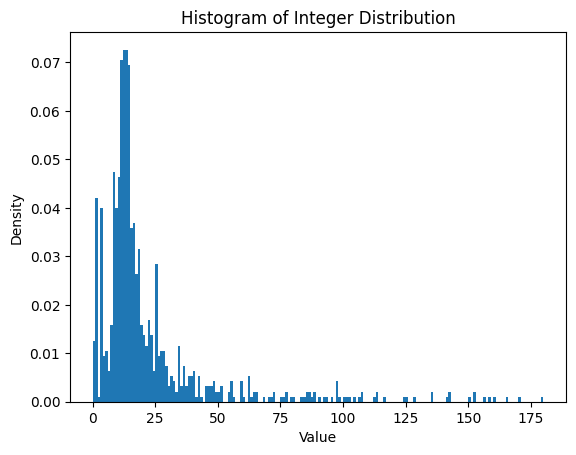

In [56]:
import matplotlib.pyplot as plt

numbers = distlist

plt.figure()
plt.hist(
    numbers,
    bins=range(min(numbers), max(numbers) + 2),
    density=True
)

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram of Integer Distribution")
plt.show()


In [27]:
with open('/Users/artem.semidetnov/Desktop/MetaGenerator_v1/ModelInteraction/testsmall', 'w') as f:
    for d in distlist:
        f.write(str(d)+'\n')

In [57]:
import statistics
median = statistics.median(numbers)
median

14.0

In [70]:
cnt = sum(1 for x in numbers if x < 5)
print(cnt)

t = 1
small_numbers = []
for i, x in enumerate(numbers):
    if x < 5:
        small_numbers.append(i)


100


In [44]:
statistics.quantiles(numbers, n=100)[20]

2.0

In [69]:
with open('/Users/artem.semidetnov/Desktop/MetaGenerator_v1/ModelInteraction/testlarger', 'w') as f:
    for i in small_numbers:
        f.write(str(test_model_dist(test_prompts[i])) + '\n')

In [9]:
answers = [test_model_dist(test_prompts[i])[0] for i in range(950)]

In [13]:
cnt = sum(1 for x in answers if x.startswith('\lam p'))

In [14]:
cnt

468

In [15]:
data = parse_concatenated_json('/Users/artem.semidetnov/Desktop/MetaGenerator_v1/datasets/data1/data.json')

In [16]:
cntr = sum(1 for d in data if d['Expression'].startswith('\lam'))
cntr

5490